# Time Series Forecasting w/ Facebook's Prophet

Adopted from https://facebook.github.io/prophet/docs/quick_start.html. 

Other good resources include: 
https://xang1234.github.io/prophet/.

By default, Prophet uses an additive model

\begin{align}
y(t) = g(t) + s(t) + h(t) + \epsilon_t \\
\end{align}

where 
g(t) represents the trend, s(t) the periodic (i.e. seasonal) component, 
h(t) holiday related events and ϵ_t the error. 
The periodic component can be broken into monthly seasonality and weekly seasonality components.
The model can also be switched to use 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import git
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [2]:
# Facebook's Open Source Time Series Analysis Tool
# pip install pystan
# pip install fbprophet
# If above ^ command doesn't install, see below issue
# https://github.com/facebook/prophet/issues/775
# pip install fbprophet --no-cache-dir --no-binary :all:
# Also for interactive visualizations you can install Plotly
# pip install plotly
import datetime
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [3]:
df = pd.read_csv(f"{homedir}/data/us/flu/cases/ILI_Ages.csv")

In [4]:
df.head()

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,National,X,1997,40,1.10148,1.21686,179,X,157,205,X,29,570,192,46842
1,National,X,1997,41,1.20007,1.28064,199,X,151,242,X,23,615,191,48023
2,National,X,1997,42,1.37876,1.23906,228,X,153,266,X,34,681,219,54961
3,National,X,1997,43,1.19920,1.14473,188,X,193,236,X,36,653,213,57044
4,National,X,1997,44,1.65618,1.26112,217,X,162,280,X,41,700,213,55506


In [5]:
# Prophet requires daily data, so we will just transform from week to day
def get_first_day_of_week(yr, wk):
    d = "%s-W%s" % (yr, wk)
    # The -1 and -%w pattern tells the parser to pick the Monday in that week
    firstdayofweek = datetime.datetime.strptime(d + '-1', "%Y-W%W-%w")
    return firstdayofweek

In [6]:
# Prophet also requires dates to be stored in a column called 'ds'
# And that the values to predict will be stored in a column called 'y'
y_name = "ILITOTAL"
df["ds"] = df.apply(lambda row: get_first_day_of_week(row.YEAR, row.WEEK), axis=1)
df["y"] = df[y_name]
df.tail()

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS,ds,y
1167,National,X,2020,7,5.99056,6.18745,17176,26193,X,36531,9179,5397,94476,2946,1526897,2020-02-17,94476
1168,National,X,2020,8,5.39490,5.60028,15122,22944,X,28164,8280,5116,79626,2950,1421823,2020-02-24,79626
1169,National,X,2020,9,5.08334,5.10641,13514,21767,X,24935,8147,5006,73369,2881,1436802,2020-03-02,73369
1170,National,X,2020,10,5.17801,5.28829,13380,23434,X,25452,8728,5561,76555,2794,1447633,2020-03-09,76555
1171,National,X,2020,11,5.82936,6.51981,13236,28704,X,25981,10933,6430,85284,2497,1308074,2020-03-16,85284


In [7]:
# Possible setting changes
# changepoint_prior_scale=0.5 (1 default)
# seasonality_mode='multiplicative' ('additive' default)
# Adding separate regressors to the model
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [8]:
future = m.make_future_dataframe(periods=90)
future.tail()

,ds
1257,2020-06-10
1258,2020-06-11
1259,2020-06-12
1260,2020-06-13
1261,2020-06-14


In [9]:
forecast = m.predict(future)

In [10]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1257,2020-06-10,37713.580163,20200.995417,42901.736588,37711.468181,37718.746632,-6052.959811,-6052.959811,-6052.959811,-6052.959811,-6052.959811,-6052.959811,0.0,0.0,0.0,31660.620351
1258,2020-06-11,37727.765831,20319.357591,42650.796255,37725.561628,37733.135946,-6135.101427,-6135.101427,-6135.101427,-6135.101427,-6135.101427,-6135.101427,0.0,0.0,0.0,31592.664404
1259,2020-06-12,37741.951500,20643.993980,42029.094961,37739.634569,37747.564184,-6213.271918,-6213.271918,-6213.271918,-6213.271918,-6213.271918,-6213.271918,0.0,0.0,0.0,31528.679582
1260,2020-06-13,37756.137168,19645.748919,42355.515889,37753.707510,37761.957311,-6287.087857,-6287.087857,-6287.087857,-6287.087857,-6287.087857,-6287.087857,0.0,0.0,0.0,31469.049311
1261,2020-06-14,37770.322837,20536.798677,42207.352902,37767.780451,37776.377712,-6356.284341,-6356.284341,-6356.284341,-6356.284341,-6356.284341,-6356.284341,0.0,0.0,0.0,31414.038496


In [11]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1257,2020-06-10,31660.620351,20200.995417,42901.736588
1258,2020-06-11,31592.664404,20319.357591,42650.796255
1259,2020-06-12,31528.679582,20643.993980,42029.094961
1260,2020-06-13,31469.049311,19645.748919,42355.515889
1261,2020-06-14,31414.038496,20536.798677,42207.352902


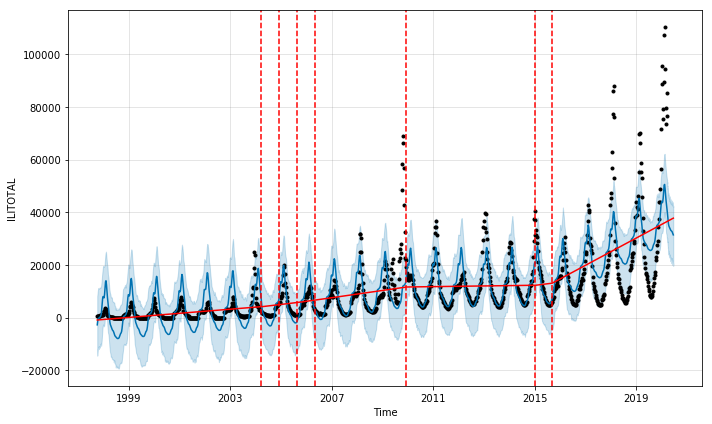

In [13]:
# Note that H1N1 outbreak and increased volumn of patients break the forecast
fig1 = m.plot(forecast, xlabel="Time", ylabel=y_name)
# Uncomment to see where the trend line changes
a=add_changepoints_to_plot(fig1.gca(), m, forecast)

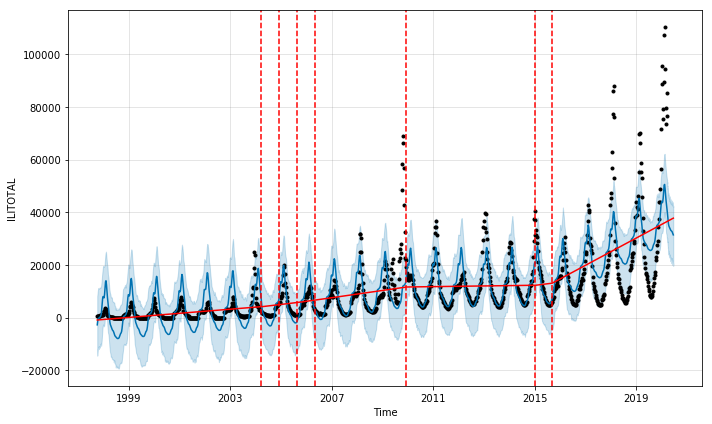

In [14]:
fig1 = m.plot(forecast, xlabel="Time", ylabel=y_name)
# Uncomment to see where the trend line changes
a=add_changepoints_to_plot(fig1.gca(), m, forecast)

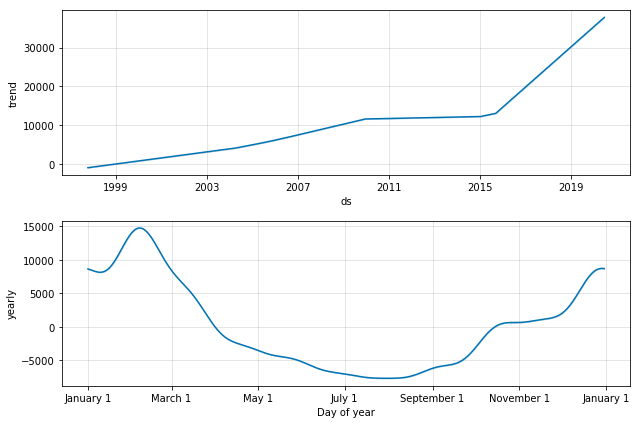

In [15]:
# Plot the yearly trends and monthly seasonality component
fig2 = m.plot_components(forecast)

In [16]:
# Cross Validation to measure forecast error
# Note: This takes a couple min (3-5)
%time df_cv = cross_validation(m, initial='4000 days', period='30 days', horizon = '365 days')

INFO:fbprophet:Making 128 forecasts with cutoffs between 2008-10-10 00:00:00 and 2019-03-17 00:00:00


Wall time: 3min 53s


In [17]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,1.129062e+08,10625.734070,6593.487167,0.504941,0.371923,0.683894
1,38 days,1.171518e+08,10823.668752,6655.846265,0.506498,0.374521,0.682683
2,39 days,1.158888e+08,10765.164611,6631.847020,0.505588,0.378362,0.682393
3,40 days,1.179111e+08,10858.688365,6702.981327,0.509829,0.378362,0.678345
4,41 days,1.177544e+08,10851.468205,6701.374714,0.509804,0.382756,0.680013
